In [24]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


rfm = pd.read_csv("../data/rfm_modeled.csv")
rfm_pca = pd.read_csv("../data/rfm_pca.csv")
rfm_scaled = pd.read_csv("../data/rfm_scaled.csv")


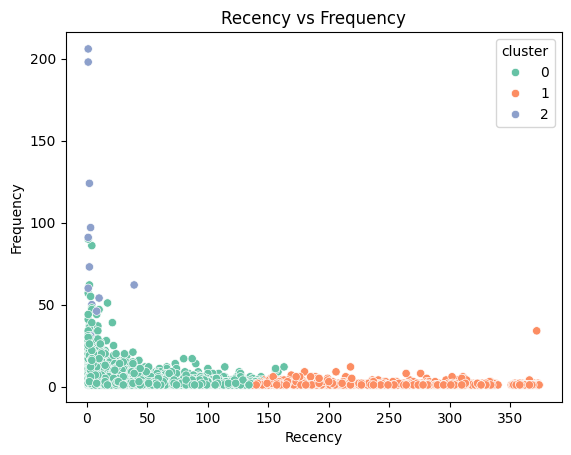

In [25]:
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Frequency',
    hue='cluster',
    palette='Set2'
)
plt.title('Recency vs Frequency')
plt.show()


**O cluster 2 (Azul)** tem Alta Frequência e baixa recência, ou seja, compram muitas vezes e ficam pouco tempo sem fazer novas compras.

**O cluster 1 (Vermelho)** tem baixa frequência e recência alta, ou seja, compram poucas vezes e demoram pra fazer novas compras

**o cluster 0 (verde)** tem variedade na frequência, em geral ficando entre o cluster 1 e o cluster 2 e uma recência média.

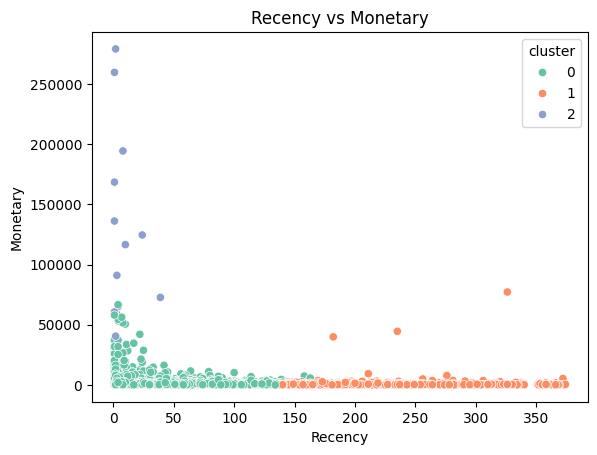

In [26]:
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='cluster',
    palette='Set2'
)
plt.title('Recency vs Monetary')
plt.show()


Ao analisar exclusivamente a variável **Monetary**, observa-se que os **maiores valores de gasto estão concentrados no Cluster 2 (azul)**, reforçando seu perfil de clientes de alto valor para o negócio.

**Os Clusters 0 e 1** compartilham uma faixa semelhante de valores monetários na maior parte dos registros. No entanto, o **Cluster 0 se destaca por conter alguns clientes com valores de gasto superiores**, indicando a presença de clientes com potencial de crescimento e maior ticket médio dentro desse grupo.

In [27]:
rfm['cluster'].value_counts()

cluster
0    3227
1    1094
2      14
Name: count, dtype: int64

**Temos apenas 14 clientes no cluster 2, a maioria está no cluster 0 1094 clientes no cluster 1**

In [28]:
rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].median().round(1)

,Recency,Frequency,Monetary
cluster,,,
0,30.0,3.0,912.2
1,241.0,1.0,309.5
2,2.5,61.0,103811.2


Utilizando a mediana, uma métrica robusta que minimiza a influência de valores extremos, é possível caracterizar de forma mais fiel o comportamento de cada cluster:

**Cluster 0** apresenta uma recência mediana de **30 dias**, indicando que, em média, seus clientes levam cerca de um mês para realizar uma nova compra. Esse grupo possui uma frequência mediana de **3 compras** e um monetary mediano de **912,3 euros**. Em termos relativos, trata-se do cluster com a **segunda maior recência, segunda maior frequência e segundo maior valor monetário**, representando clientes com bom engajamento e valor consistente.

**Cluster 1** possui uma recência mediana de **241 dias**, o que indica um longo intervalo entre compras, caracterizando clientes pouco recorrentes ou em risco de churn. Além disso, apresentam uma frequência mediana de apenas **1 compra** e um monetary mediano de **309,5 euros**, evidenciando baixo engajamento e menor contribuição financeira.

**Cluster 2** destaca-se como **o grupo mais valioso**, com uma recência mediana de apenas **2,5 dias**, indicando compras extremamente frequentes. Esse comportamento é reforçado por uma frequência mediana de **61 compras**. Consequentemente, este cluster apresenta um monetary mediano de **103.811,2** euros, demonstrando um altíssimo nível de engajamento e valor para o negócio.

## Análise exploratória dos dados usando PCA :

O PCA foi aplicado apenas com o objetivo de **visualizar os clusters em duas dimensões**.
Como o método reduz a dimensionalidade dos dados, **parte da informação é perdida na projeção**, o que pode causar sobreposição visual entre clusters e alterações aparentes na distribuição dos pontos.
O KMeans foi treinado no espaço original dos dados RFM escalados, sendo este o resultado válido do modelo. O gráfico em PCA deve ser interpretado apenas como uma ferramenta exploratória.

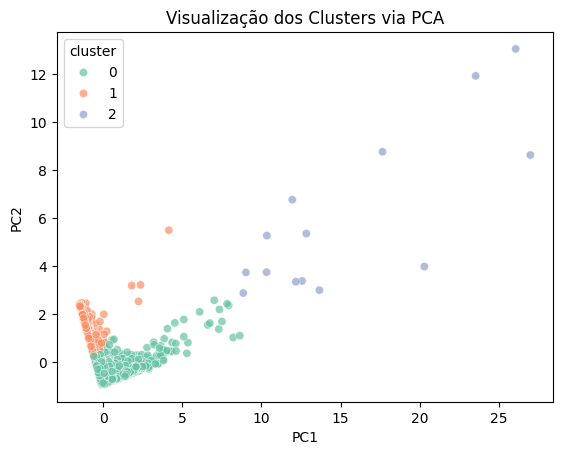

In [ ]:
rfm_pca['cluster'] = rfm['cluster']

sns.scatterplot(
    data=rfm_pca,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)
plt.title('Visualização dos Clusters via PCA')
plt.show()



In [30]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm['cluster_db'] = dbscan.fit_predict(rfm_scaled)

In [31]:
rfm['cluster_db'].value_counts()

cluster_db
 0    4293
-1      42
Name: count, dtype: int64

Através do DBSCAN o algoritmo marca como valores negativos os **outliters**, tamos portanto 42 valores extremos e iremos retirá-los

### Visualizando os valores extremos :

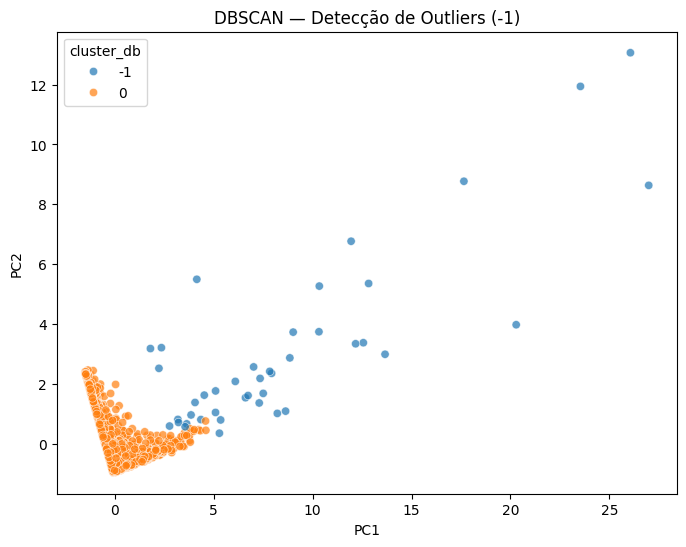

In [32]:
rfm_pca_db = rfm_pca.copy()
rfm_pca_db['cluster_db'] = rfm['cluster_db']

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_pca_db,
    x='PC1',
    y='PC2',
    hue='cluster_db',
    palette='tab10',
    alpha=0.7
)
plt.title('DBSCAN — Detecção de Outliers (-1)')
plt.show()

In [33]:
rfm_clean = rfm[rfm['cluster_db'] != -1].copy()
rfm_scaled_clean = rfm_scaled[rfm['cluster_db'] != -1]

Aplicamos DBSCAN como método complementar para identificação de clientes atípicos. Os pontos classificados como ruído (-1) foram removidos antes do treinamento final do KMeans, resultando em clusters mais estáveis e representativos do comportamento predominante da base.”

In [34]:
kmeans = KMeans(n_clusters=3, random_state=2, n_init=20)
rfm_clean['cluster'] = kmeans.fit_predict(rfm_scaled_clean)


In [35]:
pca = PCA(n_components=2)

rfm_pca_clean = pca.fit_transform(rfm_scaled_clean)
rfm_pca_clean = pd.DataFrame(
    rfm_pca_clean,
    columns=['PC1', 'PC2'],
    index=rfm_clean.index
)

rfm_pca_clean['cluster'] = rfm_clean['cluster']


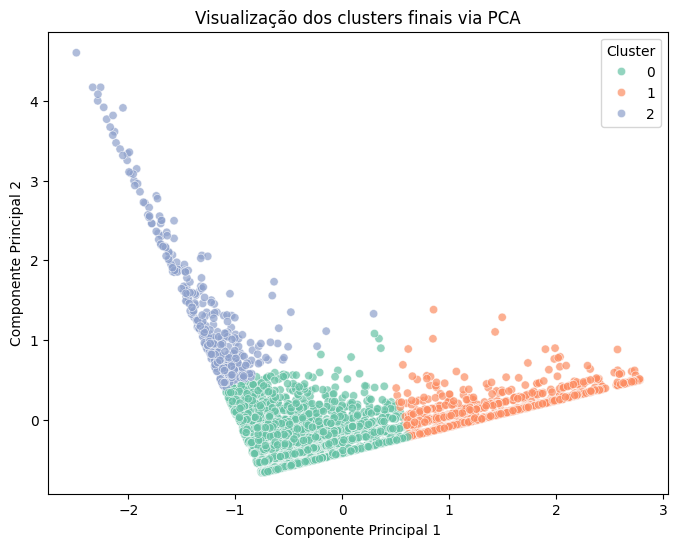

In [36]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=rfm_pca_clean,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)

plt.title('Visualização dos clusters finais via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

Ao plotar os clusters no espaço PCA bidimensional podemos ver explicitamente a separação de cada segmento

Ao aplicar o PCA, observamos que o Cluster 0 aparenta conter mais pontos do que o esperado quando comparado à distribuição original dos clusters. Esse efeito ocorre porque o PCA reduz a dimensionalidade dos dados, projetando variáveis originalmente separadas em um espaço de menor dimensão (geralmente 2D), o que pode causar sobreposição visual entre clusters.

É importante destacar que o PCA não altera o resultado do KMeans, pois o modelo foi treinado no espaço original (RFM escalado). O PCA é utilizado exclusivamente para visualização, permitindo observar padrões e separações de forma mais intuitiva, ainda que com perda de informação.

No nosso caso, os dois primeiros componentes principais explicam aproximadamente 86% da variância total, o que é um valor alto, mas não perfeito. Os cerca de 14% restantes contêm informações que ajudam o algoritmo a separar melhor os clusters, mas que não são visíveis no plano 2D.

### Análise estatística dos clusters

In [37]:
rfm_cluster_summary = (
    rfm_clean
    .groupby('cluster')
    .agg(
        customers=('CustomerID', 'count'),
        recency_mean=('Recency', 'mean'),
        recency_median=('Recency', 'median'),
        frequency_mean=('Frequency', 'mean'),
        frequency_median=('Frequency', 'median'),
        monetary_mean=('Monetary', 'mean'),
        monetary_median=('Monetary', 'median')
    ) )

rfm_cluster_summary['R_rank'] = rfm_cluster_summary['recency_median'].rank(ascending=True)
rfm_cluster_summary['F_rank'] = rfm_cluster_summary['frequency_median'].rank(ascending=False)
rfm_cluster_summary['M_rank'] = rfm_cluster_summary['monetary_median'].rank(ascending=False)

rfm_cluster_summary.sort_values(
    by=['R_rank', 'F_rank', 'M_rank']
)

,customers,recency_mean,recency_median,frequency_mean,frequency_median,monetary_mean,monetary_median,R_rank,F_rank,M_rank
cluster,,,,,,,,,,
2,362,14.331492,9.0,15.538674,13.0,6096.903674,4805.42,1.0,1.0,1.0
0,2872,45.714485,36.0,3.167479,3.0,1151.251692,744.19,2.0,2.0,2.0
1,1059,249.221907,244.0,1.542021,1.0,473.079679,307.90,3.0,3.0,3.0



**Cluster 2 – clientes VIP**

Clientes com menor recency, maior frequência e maior gasto monetário. São os mais engajados e mais valiosos da base.

**Cluster 1 – clinentes regulares**

Ocupa a posição intermediária (2º lugar) em recency, frequency e monetary. Representa clientes ativos, mas sem comportamento premium.

**Cluster 0 – clientes nativos / Baixo valor**

Apresenta os piores indicadores (3º lugar) em todas as métricas: maior recency, menor frequência e menor gasto.

In [38]:
rfm_clean['cluster'].value_counts(normalize=True) * 100

cluster
0    66.899604
1    24.668064
2     8.432332
Name: proportion, dtype: float64

Temos aproximadamente **67%** de clientes regulares, **25%** de clientes de baixo retorno e apenas **8%** de clientes VIP.
O objetivo deste projeto é de identificar quais clientes se adequam a qual categoria e com issoa aplicar métodos de retenção para cada segmento e também buscar trazer clientes novos ou inativos.

**Melhorias para retenção :**

**O cluster 2 (VIP)** deve ser fidelizado com benefícios exclusivos e ações de valorização, pois tem menor recency e maior frequência e gasto. Pode ser implementado acesso antecipado a novidades e recompensas por indicação.


**O cluster 1 (Regulares)** pode evoluir com incentivos à recompra e promoções especiais, lembretes de recompra e incentivos progressivos para migrar ao grupo VIP explicando todos os benefícios.

**O cluster 0 (Inativos)** deve receber campanhas de reativação com ofertas diretas, promoções, campanhas “volte e ganhe”, cupons com prazo curto, comunicação personalizada, lembretes automáticos após longo tempo sem compra, bundles de baixo custo, remarketing, pesquisas rápidas para entender o motivo da saída